In [1]:
from PIL import Image
import argparse
import matplotlib.pyplot as plt
import sys
import random
import numpy as np
import os

import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary

import bqplot.scales
import ipyvolume as ipv
import ipywidgets as widgets

from collections import OrderedDict

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
print(device)


cuda:0


In [2]:
def unpack(compressed):
  ''' given a bit encoded voxel grid, make a normal voxel grid out of it.  '''
  uncompressed = np.zeros(compressed.shape[0] * 8, dtype=np.uint8)
  uncompressed[::8] = compressed[:] >> 7 & 1
  uncompressed[1::8] = compressed[:] >> 6 & 1
  uncompressed[2::8] = compressed[:] >> 5 & 1
  uncompressed[3::8] = compressed[:] >> 4 & 1
  uncompressed[4::8] = compressed[:] >> 3 & 1
  uncompressed[5::8] = compressed[:] >> 2 & 1
  uncompressed[6::8] = compressed[:] >> 1 & 1
  uncompressed[7::8] = compressed[:] & 1

  return uncompressed

class KittiLoader(Dataset):
    def __init__(self, root_dir, mode='train', sequences=['00'], split_ratio=1.0, 
                 get_vox_lidar=False, get_vox_invalid=False, get_vox_occluded=False):
        self.root_dir = root_dir
        self.mode = mode
        self.sequences = sequences
        self.image_names = []
        self.image2_dir = {}
        self.image3_dir = {}
        self.voxels_dir = {}
        self.get_vox_lidar=get_vox_lidar
        self.get_vox_invalid=get_vox_invalid
        self.get_vox_occluded=get_vox_occluded
        
        self.scene_size = [51.2, 51.2, 6.4] #unit m, 51.2m = 256 * 0.2m
        self.vox_origin = [0, -25.6, -2]#unit m
        self.voxel_size = 0.2  #m

        for seq in self.sequences:
            self.image2_dir[seq] = os.path.join(root_dir, 'sequences', seq, 'image_2')
            self.image3_dir[seq] = os.path.join(root_dir, 'sequences', seq, 'image_3')
            self.voxels_dir[seq] = os.path.join(root_dir, 'sequences', seq, 'voxels')
            seq_image_names = [f.split('.')[0] for f in os.listdir(self.image2_dir[seq]) if f.endswith('.png')]
            self.image_names.extend([(seq, img_name) for img_name in seq_image_names])
        
        split_idx = int(len(self.image_names) * split_ratio )
        
        if self.mode == 'train':
            self.image_names = self.image_names[:split_idx]
        else:
            self.image_names = self.image_names[split_idx:]
        
        # Define transformations for standardization and conversion to tensor
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Standard ImageNet mean
                                 std=[0.229, 0.224, 0.225])  # Standard ImageNet std
        ])

        self.class_map = {
            0 : 0,     # "unlabeled"
            1 : 0,     # "outlier" mapped to "unlabeled" --------------------------mapped
            10: 1,     # "car"
            11: 1,     # "bicycle"
            13: 1,     # "bus" mapped to "other-vehicle" --------------------------mapped
            15: 1,     # "motorcycle"
            16: 1,     # "on-rails" mapped to "other-vehicle" ---------------------mapped
            18: 1,     # "truck"
            20: 1,     # "other-vehicle"
            30: 1,     # "person"
            31: 1,     # "bicyclist"
            32: 1,     # "motorcyclist"
            40: 3,     # "road"
            44: 2,    # "parking"
            48: 4,    # "sidewalk"
            49: 4,    # "other-ground"
            50: 2,    # "building"
            51: 2,    # "fence"
            52: 2,     # "other-structure" mapped to "unlabeled" ------------------mapped ####
            60: 3,     # "lane-marking" to "road" ---------------------------------mapped
            70: 5,    # "vegetation"
            71: 5,    # "trunk"
            72: 3,    # "terrain"
            80: 2,    # "pole"
            81: 2,    # "traffic-sign"
            99: 1,     # "other-object" to "unlabeled" ----------------------------mapped ####
            252: 1,    # "moving-car" to "car" ------------------------------------mapped
            253: 1,    # "moving-bicyclist" to "bicyclist" ------------------------mapped
            254: 1,    # "moving-person" to "person" ------------------------------mapped
            255: 1,    # "moving-motorcyclist" to "motorcyclist" ------------------mapped
            256: 1,    # "moving-on-rails" mapped to "other-vehicle" --------------mapped
            257: 1,    # "moving-bus" mapped to "other-vehicle" -------------------mapped
            258: 1,    # "moving-truck" to "truck" --------------------------------mapped
            259: 1,    # "moving-other"-vehicle to "other-vehicle" ----------------mapped
        }
        
        self.class_names = [
            "empty", #0
            "obstacles", #1
            "building", #2
            "road", #3
            "sidewalk", #4
            "vegetation", #5
            "unknown", #6
        ]

        



    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        seq, img_name = self.image_names[idx]
        img2_name = os.path.join(self.image2_dir[seq], img_name + '.png')
        img3_name = os.path.join(self.image3_dir[seq], img_name + '.png')
        if self.get_vox_lidar:
            voxel_name = os.path.join(self.voxels_dir[seq], img_name + '.bin')
        label_name = os.path.join(self.voxels_dir[seq], img_name + '.label')
        if self.get_vox_invalid:
            invalid_name = os.path.join(self.voxels_dir[seq], img_name + '.invalid')
        if self.get_vox_occluded:
            occluded_name = os.path.join(self.voxels_dir[seq], img_name + '.occluded')
        
        
        # Load and transform images
        left_image = self.transform(Image.open(img2_name).convert('RGB'))
        right_image = self.transform(Image.open(img3_name).convert('RGB'))

        extra_data = []
        # Load voxel data and convert to tensor
        if self.get_vox_lidar:
            voxel_data = torch.tensor(unpack(np.fromfile(voxel_name, dtype=np.uint8)).reshape(256, 256, 32).astype(np.float32))
            extra_data.append(voxel_data)
        #  0 invalid 1-19 class and 255 invalid
        voxel_labels = np.fromfile(label_name, dtype=np.uint16).reshape(256, 256, 32).astype(np.float32)
        voxel_labels = torch.tensor(np.vectorize(self.class_map.get)(voxel_labels))
        #print(voxel_data.shape)
        #print(voxel_labels.shape)
        
        if self.get_vox_occluded:
            voxel_occluded = torch.tensor(unpack(np.fromfile(occluded_name, dtype=np.uint8)).reshape(256, 256, 32).astype(np.float32))
            extra_data.append(voxel_occluded)
        
        if self.get_vox_invalid:
            voxel_invalid = torch.tensor(unpack(np.fromfile(invalid_name, dtype=np.uint8)).reshape(256, 256, 32).astype(np.float32))
            extra_data.append(voxel_invalid)
        
        
        
        if len(extra_data) != 0:
            return left_image, right_image, voxel_labels, tuple(extra_data)
        else:
            return left_image, right_image, voxel_labels
    
    
    def get_data(self, idx):
        return self.__getitem__(idx)









In [3]:
def voxel_to_coordinates(voxel_data, voxel_size=0.01, threshold = 0):
    # 获取体素数据的形状
    xx, yy, zz = voxel_data.shape

    # 初始化坐标和标签列表
    x_coords = []
    y_coords = []
    z_coords = []
    tags = []

    # 遍历体素数据
    for x in range(xx):
        for y in range(yy):
            for z in range(zz):
                tag = voxel_data[x, y, z]
                # 只记录非零标签的体素
                if tag > threshold:
                    x_coords.append(x * voxel_size)
                    y_coords.append(y * voxel_size)
                    z_coords.append(z * voxel_size)
                    tags.append(tag)

    return np.array(x_coords), np.array(y_coords), np.array(z_coords), np.array(tags)

def visualize_labeled_array3d(voxel_data, num_classes=7, size = None, marker = None):
        voxel_data = voxel_data.astype(np.uint16)
        x, y, z, tags = voxel_to_coordinates(voxel_data, voxel_size = 1 / voxel_data.shape[0])


        # 创建颜色比例尺
        color_scale = bqplot.scales.ColorScale(min=0, max=num_classes, colors=["#f00", "#00f", "#000000", "#808080", "#0f0", "#800080"])

        fig = ipv.figure()

        # 确定tags中的唯一值
        unique_tags = np.unique(tags)

        # 为每个唯一的tag值创建一个scatter
        for tag in unique_tags:
            # 过滤出当前tag的坐标
            mask = tags == tag
            x_filtered, y_filtered, z_filtered, tags_f = x[mask], y[mask], z[mask], tags[mask]
            
            ipv.scatter(1-y_filtered,x_filtered, z_filtered, color=tags_f, color_scale=color_scale, marker=marker or 'box', size=size or 0.1, description="len({})={}".format(str(tag),x_filtered.shape[0]))
        ipv.xyzlabel('y','x','z')
        ipv.view(0, -50, distance=2.5)
        ipv.show()

def plot_tensor2d(img_tensor):
    tensor = img_tensor.permute(1, 2, 0)
    tensor = (tensor - tensor.min()) / (tensor.max() - tensor.min())
    plt.imshow(tensor)

def visualize_3D_points_in_jupyter(points_3D, size=2, marker="sphere"):
    # Assuming points_3D is a N x 3 numpy array
    x = points_3D[:, 0]
    y = points_3D[:, 1]
    z = points_3D[:, 2]

    ipv.quickscatter(x, y, z, size=size, marker=marker)
    ipv.show()

In [4]:
sys.path.append("/workspace/HKU-OccNet/")
from utils.calib_utils import *
img_width, img_height = 1241, 376
calib = read_calib("/workspace/HKU-OccNet/calib.txt")
calib_proj = get_projections(img_width, img_height, calib)
train_set = KittiLoader(root_dir="/workspace/Dataset2/dataset", mode='train', 
                        sequences=['00', '01', '02'], 
                        get_vox_lidar=True, get_vox_invalid=True, get_vox_occluded=True)

vox_origin = torch.tensor([0, 128, 10])

vf_mask = calib_proj['fov_mask_1'].view(256, 256, 32)
prj_pix = calib_proj['projected_pix_1'].view(256, 256, 32, 2)
pix_z = calib_proj['pix_z_1'].view(256, 256, 32)

cull_mask = torch.zeros((256, 256, 32)).bool()
cull_mask[:int(0.5 * 256), :, :] = True

# def preprocess_gt(voxel_labels, voxel_invalid, cull_mask, vf_mask):
#     batch_size = voxel_labels.shape[0]
#     cull_mask = cull_mask.unsqueeze(0).expand(batch_size, 256, 256, 32)
#     vf_mask = vf_mask.unsqueeze(0).expand(batch_size, 256, 256, 32)
#     v = voxel_labels.clone()
#     v[(v == 0) & (voxel_invalid > 0.5)] = 20
#     v[~vf_mask] = 0
#     v = v * cull_mask
#     return v.unsqueeze(1)

# def preprocess_gt_bool(voxel_labels, voxel_invalid, mask = None):
#     batch_size = voxel_labels.shape[0]
#     v = voxel_labels.clone()
#     v[(v == 0) & (voxel_invalid > 0.5)] = 6

#     if mask != None:
#         mask = mask.unsqueeze(0).expand(batch_size, 256, 256, 32)
#         v[~mask] = 0
        
#     v = v.unsqueeze(1) > 0.5
#     return v.float()



In [5]:
print(len(train_set))
len(train_set.class_names)


10303


7

In [6]:
# left_img, right_img, voxel_labels, extra_labels = train_set.__getitem__(random.randint(0, len(train_set)))
# voxel_lidar, voxel_occluded, voxel_invalid  = extra_labels


# plot_tensor2d(left_img)
# visualize_labeled_array3d((voxel_labels.view(256, 256, 32)).cpu().numpy(), num_classes=len(train_set.class_names), 
#                           size = 0.5, marker = 'box')


In [7]:
def preprocess_gt(voxel_labels, voxel_invalid, mask = None):
    batch_size = voxel_labels.shape[0]
    v = voxel_labels.clone()
    v = v[:, int(0.1*256):int(0.6*256), 128-64:128+64, 0:16]
    
    #vi = voxel_invalid[:, int(0.1*256):int(0.6*256), 128-64:128+64, 0:16]
    
    #print(v.shape)
    #v[(v == 0) & (voxel_occluded > 0.5)] = 6
    
    if mask != None:
        mask = mask[int(0.1*256):int(0.6*256), 128-64:128+64, 0:16]
        mask = mask.unsqueeze(0).expand(batch_size, 128, 128, 16)
        v[~mask] = 0
        
    return v
    

In [8]:
left_img, right_img, voxel_labels, extra_labels = train_set.__getitem__(random.randint(0, len(train_set)))
voxel_lidar, voxel_occluded, voxel_invalid  = extra_labels

voxel_pgt = preprocess_gt(voxel_labels.unsqueeze(0), voxel_invalid.unsqueeze(0), vf_mask)
visualize_labeled_array3d((voxel_pgt.view(128, 128, 16)).cpu().numpy(), num_classes=len(train_set.class_names), 
                                  size = 1, marker = 'box')


Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

In [9]:
#plot_tensor2d(left_img)

In [10]:
#torch.unique(voxel_pgt)

In [11]:
# left_img, right_img, voxel_labels, extra_labels = train_set.__getitem__(random.randint(0, len(train_set)))
# voxel_lidar, voxel_occluded, voxel_invalid  = extra_labels


# plot_tensor2d(left_img)
# voxel_pgt = preprocess_gt(voxel_labels.unsqueeze(0), voxel_invalid.unsqueeze(0), cull_mask, vf_mask)
# visualize_labeled_array3d((voxel_pgt.view(256, 256, 32)).cpu().numpy(), size = 0.5, marker = 'box')


In [12]:
# voxel_pgt = preprocess_gt_bool(voxel_labels.unsqueeze(0), voxel_invalid.unsqueeze(0),  vf_mask  & cull_mask)
# visualize_labeled_array3d((voxel_pgt.view(256, 256, 32)).cpu().numpy(), size = 0.5, marker = 'box')

In [13]:
# reference: https://github.com/duyphuongcri/Variational-AutoEncoder/blob/master/model.py

import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
import math 
class Conv3D_Block(nn.Module):
    def __init__(self, ch_in, ch_out, k_size, stride=1, p=1):
        super(Conv3D_Block, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv3d(ch_in, ch_out, kernel_size=k_size, stride=stride, padding=p),  
            nn.BatchNorm3d(ch_out),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        out = self.conv(x)
        return out

class ResNet3D_Block(nn.Module):
    def __init__(self, ch, k_size, stride=1, p=1):
        super(ResNet3D_Block, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv3d(ch, ch, kernel_size=k_size, stride=stride, padding=p), 
            nn.BatchNorm3d(ch),
            nn.ReLU(inplace=True),

            nn.Conv3d(ch, ch, kernel_size=k_size, stride=stride, padding=p),  
            nn.BatchNorm3d(ch),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        out = self.conv(x) + x
        return out


# class ConvUpSample3D_Block(nn.Module):
#     def __init__(self, ch_in, ch_out, k_size=1, scale=2, align_corners=False):
#         super(ConvUpSample3D_Block, self).__init__()
#         self.up = nn.Sequential(
#             nn.Conv3d(ch_in, ch_out, kernel_size=k_size),
#             nn.Upsample(scale_factor=scale, mode='trilinear', align_corners=align_corners),
#         )
#     def forward(self, x):
#         return self.up(x)

class ConvUpSample3D_Block(nn.Module):
    def __init__(self, ch_in, ch_out, k_size=3, stride=2, output_padding=1):
        super(ConvUpSample3D_Block, self).__init__()
        self.up = nn.Sequential(
            nn.ConvTranspose3d(ch_in, ch_out, kernel_size=k_size, stride=stride, padding=1, output_padding=output_padding),
            nn.BatchNorm3d(ch_out),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.up(x)

class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.conv1 = Conv3D_Block(ch_in=1, ch_out=8, k_size=3)
        self.res_block1 = ResNet3D_Block(ch=8, k_size=3)
        self.MaxPool1 = nn.MaxPool3d(3, stride=2, padding=1)

        self.conv2 = Conv3D_Block(ch_in=8, ch_out=16, k_size=3)
        self.res_block2 = ResNet3D_Block(ch=16, k_size=3)
        self.MaxPool2 = nn.MaxPool3d(3, stride=2, padding=1)

        self.conv3 = Conv3D_Block(ch_in=16, ch_out=32, k_size=3)
        self.res_block3 = ResNet3D_Block(ch=32, k_size=3)
        self.MaxPool3 = nn.MaxPool3d(3, stride=2, padding=1)

        self.conv4 = Conv3D_Block(ch_in=32, ch_out=64, k_size=3)
        self.res_block4 = ResNet3D_Block(ch=64, k_size=3)
        self.MaxPool4 = nn.MaxPool3d(3, stride=2, padding=1)

        self.z_mean = nn.Linear(64*8*8*1, latent_dim)
        self.z_log_sigma = nn.Linear(64*8*8*1, latent_dim)
            
        self.reset_parameters()
      
    def reset_parameters(self):
        for weight in self.parameters():
            if weight.dim() > 1:
                torch.nn.init.kaiming_uniform_(weight)

    def forward(self, x):
        x1 = self.conv1(x)
        x1 = self.res_block1(x1)
        x1 = self.MaxPool1(x1) 
        #print(x1.shape) 
        
        x2 = self.conv2(x1)
        x2 = self.res_block2(x2)
        x2 = self.MaxPool2(x2) 
        #print(x2.shape) 

        x3 = self.conv3(x2)
        x3 = self.res_block3(x3)
        x3 = self.MaxPool3(x3) 
        #print(x3.shape) 
        
        x4 = self.conv4(x3)
        x4 = self.res_block4(x4) 
        x4 = self.MaxPool4(x4) 
        #print(x4.shape) 
        x = x4

        x = torch.flatten(x, start_dim=1)
        
        z_mean = self.z_mean(x)
        z_log_sigma = self.z_log_sigma(x)

        # 避免数值不稳定
        z_log_sigma = torch.clamp(z_log_sigma, max=0) # 限制z_log_sigma的最大值
        
        
        return z_mean, z_log_sigma

class Decoder(nn.Module):
    def __init__(self, latent_dim, num_classes, device):
        super(Decoder, self).__init__()
        self.device = device
        
        self.latent_dim = latent_dim
        self.linear_up = nn.Linear(latent_dim, 64*8*8*1)  
        self.relu = nn.ReLU()

        # Upsampling layers
        self.upsample4 = ConvUpSample3D_Block(ch_in=64, ch_out=32, k_size=3, stride=2, output_padding=1)
        self.res_block4 = ResNet3D_Block(ch=32, k_size=3)
        
        self.upsample3 = ConvUpSample3D_Block(ch_in=32, ch_out=16, k_size=3, stride=2, output_padding=1)
        self.res_block3 = ResNet3D_Block(ch=16, k_size=3)        
        
        self.upsample2 = ConvUpSample3D_Block(ch_in=16, ch_out=8, k_size=3, stride=2, output_padding=1)
        self.res_block2 = ResNet3D_Block(ch=8, k_size=3)   
        
        # Final upsampling to reach the desired output shape
        self.upsample1 = ConvUpSample3D_Block(ch_in=8, ch_out=num_classes, k_size=3, stride=2, output_padding=1)
        self.res_block1 = ResNet3D_Block(ch=num_classes, k_size=3)   

        self.to_logits = nn.Conv3d(num_classes, num_classes, kernel_size=1)
        self.reset_parameters()
      
    def reset_parameters(self):
        for weight in self.parameters():
            if weight.dim() > 1:
                torch.nn.init.kaiming_uniform_(weight)

    def forward(self, z_mean, z_log_sigma):
        epsilon = torch.randn_like(z_log_sigma, device=self.device)
        z = z_mean + z_log_sigma.exp() * epsilon
        
        x = self.linear_up(z)
        x = self.relu(x)
        x = x.view(-1, 64, 8, 8, 1)  

        x = self.upsample4(x) 
        x = self.res_block4(x)

        x = self.upsample3(x) 
        x = self.res_block3(x)

        x = self.upsample2(x) 
        x = self.res_block2(x)

        x = self.upsample1(x) 
        x = self.res_block1(x)

        #print(x.shape)
        logits = self.to_logits(x)
        return logits


class VAE3D(nn.Module):
    def __init__(self, latent_dim=128, num_classes=6, device='cpu'):
        super(VAE3D, self).__init__()
        self.device = device
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim, num_classes, device)

        self.cross_entropy = nn.CrossEntropyLoss()
        self.reset_parameters()
      
    def reset_parameters(self):
        for weight in self.parameters():
            if weight.dim() > 1:
                torch.nn.init.kaiming_uniform_(weight)

    def forward(self, x):
        z_mean, z_log_sigma = self.encoder(x)
        y = self.decoder(z_mean, z_log_sigma)
        return y, z_mean, z_log_sigma

    def gaussian_kl_divergence(self, z_mean, z_log_sigma):
        z_log_var = z_log_sigma * 2
        kl_div = -0.5 * torch.sum(1 + z_log_var - z_mean.pow(2) - z_log_var.exp(), dim=1)
        return torch.mean(kl_div)

    def step(self, x, mask=None):
        target = x
        y, z_mean, z_log_sigma = self(x.unsqueeze(1).float()) #unsqueeze to add channel dim
        kl_loss = self.gaussian_kl_divergence(z_mean, z_log_sigma)
        ce_loss = self.cross_entropy(y, target)
        #print(kl_loss, ce_loss)
        return kl_loss * 0.001 + ce_loss
        

In [14]:
# vae3d = VAE3D(latent_dim=512, num_classes=len(train_set.class_names))
# from torchsummary import summary
# summary(vae3d, input_size=(1, 128, 128, 16), device="cpu")

In [15]:
# x = torch.rand(1, 1, 256, 256, 32)
# y, z_mean, z_log_sigma = vae3d(x)
# print(y.shape)
# print(z_mean.shape)
# print(z_log_sigma.shape)

In [15]:
from torch.utils.data import DataLoader, random_split
num_classes = len(train_set.class_names)



def rsplit(set, perc=0.7):
    split_idx = int(perc * len(set))
    return random_split(set, [split_idx, len(set) - split_idx])

train_set_small, _ = rsplit(train_set, 0.01)
train_subset, val_subset = rsplit(train_set_small, 0.85)

train_dataloader = DataLoader(train_subset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_subset, batch_size=8, shuffle=True)



print(len(train_dataloader))
print(len(val_dataloader))



11
2


In [16]:
model = VAE3D(latent_dim=512, num_classes=len(train_set.class_names), device=device)


In [20]:
from torch.optim import Adam
optimizer = Adam(model.parameters(), lr=0.001)
num_epochs = 20
best_loss = np.inf


In [21]:

model = model.to(device)

In [22]:
model.load_state_dict(torch.load('vae3d.pth', map_location=device))

<All keys matched successfully>

In [23]:
print(device)

cuda:0


In [24]:
from tqdm import tqdm
import torch.nn.functional as F



for epoch in range(num_epochs):
    train_loss = 0.0
    for i, (left_img, right_img, voxel_labels, extra_labels) in tqdm(enumerate(train_dataloader),
                                                                     total = len(train_dataloader)):
        voxel_lidar, voxel_occluded, voxel_invalid  = extra_labels
        voxel_labels = voxel_labels.to(device)
        voxel_invalid = voxel_invalid.to(device)
        voxel_pgt = preprocess_gt(voxel_labels, voxel_invalid, (vf_mask).to(device))
        loss = model.step(voxel_pgt)
        
        optimizer.zero_grad()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=20.0)
        
        optimizer.step()
        train_loss += loss.item()
        #print(loss.item())  
    valid_loss = 0.0
    
    model.eval()
    with torch.no_grad():
        for (left_img, right_img, voxel_labels, extra_labels) in tqdm(val_dataloader):
            voxel_lidar, voxel_occluded, voxel_invalid  = extra_labels
            voxel_labels = voxel_labels.to(device)
            voxel_invalid = voxel_invalid.to(device)
            voxel_pgt = preprocess_gt(voxel_labels, voxel_invalid, (vf_mask).to(device))
            loss = model.step(voxel_pgt)
            
            loss = model.step(voxel_pgt)
            optimizer.zero_grad()
            loss.requires_grad_(True)
            loss.backward()
            optimizer.step()
            valid_loss += loss.item()
            
    print(f'Epoch {epoch + 1}: Training loss: {train_loss / len(train_dataloader)}, Validation loss: {valid_loss / len(val_dataloader)}')
    if (train_loss / len(train_dataloader)) < best_loss:
        torch.save(model.state_dict(), 'vae3d.pth')
        best_loss = (train_loss / len(train_dataloader))

100%|██████████| 2/2 [00:08<00:00,  4.21s/it]


Epoch 1: Training loss: 3.3602790399031206, Validation loss: 1.9606242775917053


100%|██████████| 2/2 [00:08<00:00,  4.29s/it]


Epoch 2: Training loss: 1.2109606970440259, Validation loss: 0.8533928990364075


100%|██████████| 2/2 [00:08<00:00,  4.19s/it]


Epoch 3: Training loss: 0.7580262856049971, Validation loss: 0.7259095907211304


100%|██████████| 2/2 [00:08<00:00,  4.25s/it]


Epoch 4: Training loss: 0.6888483545996926, Validation loss: 0.685145914554596


100%|██████████| 2/2 [00:08<00:00,  4.24s/it]


Epoch 5: Training loss: 0.6603118831461127, Validation loss: 0.6655793190002441


100%|██████████| 2/2 [00:08<00:00,  4.24s/it]


Epoch 6: Training loss: 0.6419658010656183, Validation loss: 0.6490777432918549


100%|██████████| 2/2 [00:08<00:00,  4.12s/it]


Epoch 7: Training loss: 0.628750741481781, Validation loss: 0.6390621960163116


100%|██████████| 2/2 [00:08<00:00,  4.15s/it]


Epoch 8: Training loss: 0.6179556413130327, Validation loss: 0.6294228136539459


100%|██████████| 2/2 [00:08<00:00,  4.11s/it]


Epoch 9: Training loss: 0.6108277494257147, Validation loss: 0.6228632032871246


100%|██████████| 2/2 [00:08<00:00,  4.14s/it]


Epoch 10: Training loss: 0.604053405198184, Validation loss: 0.6168371438980103


100%|██████████| 2/2 [00:08<00:00,  4.20s/it]


Epoch 11: Training loss: 0.5971827507019043, Validation loss: 0.6109428703784943


100%|██████████| 2/2 [00:08<00:00,  4.06s/it]


Epoch 12: Training loss: 0.5921808318658308, Validation loss: 0.6096673607826233


100%|██████████| 2/2 [00:08<00:00,  4.15s/it]


Epoch 13: Training loss: 0.5875736474990845, Validation loss: 0.6025175750255585


100%|██████████| 2/2 [00:08<00:00,  4.06s/it]


Epoch 14: Training loss: 0.5808246515013955, Validation loss: 0.5974823236465454


100%|██████████| 2/2 [00:08<00:00,  4.11s/it]


Epoch 15: Training loss: 0.5753607533194802, Validation loss: 0.5945776700973511


100%|██████████| 2/2 [00:08<00:00,  4.04s/it]


Epoch 16: Training loss: 0.5718577422878959, Validation loss: 0.589219868183136


100%|██████████| 2/2 [00:08<00:00,  4.20s/it]


Epoch 17: Training loss: 0.5680604414506392, Validation loss: 0.5842735767364502


100%|██████████| 2/2 [00:08<00:00,  4.09s/it]


Epoch 18: Training loss: 0.5639674826101824, Validation loss: 0.5805777907371521


100%|██████████| 2/2 [00:08<00:00,  4.04s/it]


Epoch 19: Training loss: 0.5609464970501986, Validation loss: 0.5833864808082581


100%|██████████| 2/2 [00:08<00:00,  4.18s/it]

Epoch 20: Training loss: 0.5581271160732616, Validation loss: 0.5791023671627045


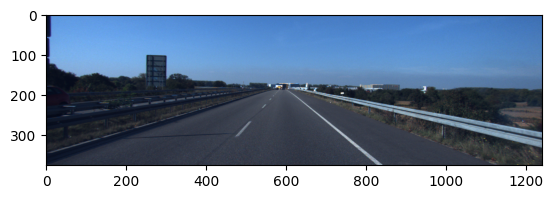

In [25]:
left_img, right_img, voxel_labels, extra_labels = train_subset.__getitem__(random.randint(0, len(train_subset)))
voxel_lidar, voxel_occluded, voxel_invalid  = extra_labels
voxel_labels = voxel_labels.unsqueeze(0).to(device)
voxel_invalid = voxel_invalid.unsqueeze(0).to(device)
voxel_pgt = preprocess_gt(voxel_labels, voxel_invalid, (vf_mask).to(device))
model.eval()
with torch.no_grad():
    y, z_mean, z_log_sigma = model(voxel_pgt.unsqueeze(1).float())


plot_tensor2d(left_img)


In [26]:
pred = torch.argmax(y, dim=1)

In [27]:
visualize_labeled_array3d((pred.view(128, 128, 16).float()).detach().cpu().numpy(), size = 1, marker = 'box')

Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

In [28]:
visualize_labeled_array3d((voxel_pgt.view(128, 128, 16)).detach().cpu().numpy(), size = 1, marker = 'box')

Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

In [ ]:
import torch
import numpy as np
from torch import nn
from torch.nn import functional as F
from typing import List, Callable, Union, Any, TypeVar, Tuple
Tensor = TypeVar('torch.tensor')
from abc import abstractmethod

class BaseVAE(nn.Module):
    
    def __init__(self) -> None:
        super(BaseVAE, self).__init__()

    def encode(self, input: Tensor) -> List[Tensor]:
        raise NotImplementedError

    def decode(self, input: Tensor) -> Any:
        raise NotImplementedError

    def sample(self, batch_size:int, current_device: int, **kwargs) -> Tensor:
        raise NotImplementedError

    def generate(self, x: Tensor, **kwargs) -> Tensor:
        raise NotImplementedError

    @abstractmethod
    def forward(self, *inputs: Tensor) -> Tensor:
        pass

    @abstractmethod
    def loss_function(self, *inputs: Any, **kwargs) -> Tensor:
        pass


class CategoricalVAE(BaseVAE):

    def __init__(self,
                 in_channels: int,
                 latent_dim: int,
                 categorical_dim: int = 40, # Num classes
                 hidden_dims: List = None,
                 temperature: float = 0.5,
                 anneal_rate: float = 3e-5,
                 anneal_interval: int = 100, # every 100 batches
                 alpha: float = 30.,
                 **kwargs) -> None:
        super(CategoricalVAE, self).__init__()

        self.latent_dim = latent_dim
        self.categorical_dim = categorical_dim
        self.temp = temperature
        self.min_temp = temperature
        self.anneal_rate = anneal_rate
        self.anneal_interval = anneal_interval
        self.alpha = alpha

        modules = []
        if hidden_dims is None:
            hidden_dims = [32, 64, 128, 256, 512]

        # Build Encoder
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels=h_dim,
                              kernel_size= 3, stride= 2, padding  = 1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU())
            )
            in_channels = h_dim

        self.encoder = nn.Sequential(*modules)
        self.fc_z = nn.Linear(hidden_dims[-1]*4,
                               self.latent_dim * self.categorical_dim)

        # Build Decoder
        modules = []

        self.decoder_input = nn.Linear(self.latent_dim * self.categorical_dim
                                       , hidden_dims[-1] * 4)

        hidden_dims.reverse()

        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i],
                                       hidden_dims[i + 1],
                                       kernel_size=3,
                                       stride = 2,
                                       padding=1,
                                       output_padding=1),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU())
            )



        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
                            nn.ConvTranspose2d(hidden_dims[-1],
                                               hidden_dims[-1],
                                               kernel_size=3,
                                               stride=2,
                                               padding=1,
                                               output_padding=1),
                            nn.BatchNorm2d(hidden_dims[-1]),
                            nn.LeakyReLU(),
                            nn.Conv2d(hidden_dims[-1], out_channels= 3,
                                      kernel_size= 3, padding= 1),
                            nn.Tanh())
        self.sampling_dist = torch.distributions.OneHotCategorical(1. / categorical_dim * torch.ones((self.categorical_dim, 1)))

    def encode(self, input: Tensor) -> List[Tensor]:
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        :param input: (Tensor) Input tensor to encoder [B x C x H x W]
        :return: (Tensor) Latent code [B x D x Q]
        """
        result = self.encoder(input)
        result = torch.flatten(result, start_dim=1)

        # Split the result into mu and var components
        # of the latent Gaussian distribution
        z = self.fc_z(result)
        z = z.view(-1, self.latent_dim, self.categorical_dim)
        return [z]

    def decode(self, z: Tensor) -> Tensor:
        """
        Maps the given latent codes
        onto the image space.
        :param z: (Tensor) [B x D x Q]
        :return: (Tensor) [B x C x H x W]
        """
        result = self.decoder_input(z)
        result = result.view(-1, 512, 2, 2)
        result = self.decoder(result)
        result = self.final_layer(result)
        return result

    def reparameterize(self, z: Tensor, eps:float = 1e-7) -> Tensor:
        """
        Gumbel-softmax trick to sample from Categorical Distribution
        :param z: (Tensor) Latent Codes [B x D x Q]
        :return: (Tensor) [B x D]
        """
        # Sample from Gumbel
        u = torch.rand_like(z)
        g = - torch.log(- torch.log(u + eps) + eps)

        # Gumbel-Softmax sample
        s = F.softmax((z + g) / self.temp, dim=-1)
        s = s.view(-1, self.latent_dim * self.categorical_dim)
        return s


    def forward(self, input: Tensor, **kwargs) -> List[Tensor]:
        q = self.encode(input)[0]
        z = self.reparameterize(q)
        return  [self.decode(z), input, q]

    def loss_function(self,
                      *args,
                      **kwargs) -> dict:
        """
        Computes the VAE loss function.
        KL(N(\mu, \sigma), N(0, 1)) = \log \frac{1}{\sigma} + \frac{\sigma^2 + \mu^2}{2} - \frac{1}{2}
        :param args:
        :param kwargs:
        :return:
        """
        recons = args[0]
        input = args[1]
        q = args[2]

        q_p = F.softmax(q, dim=-1) # Convert the categorical codes into probabilities

        kld_weight = kwargs['M_N'] # Account for the minibatch samples from the dataset
        batch_idx = kwargs['batch_idx']

        # Anneal the temperature at regular intervals
        if batch_idx % self.anneal_interval == 0 and self.training:
            self.temp = np.maximum(self.temp * np.exp(- self.anneal_rate * batch_idx),
                                   self.min_temp)

        recons_loss =F.mse_loss(recons, input, reduction='mean')

        # KL divergence between gumbel-softmax distribution
        eps = 1e-7

        # Entropy of the logits
        h1 = q_p * torch.log(q_p + eps)

        # Cross entropy with the categorical distribution
        h2 = q_p * np.log(1. / self.categorical_dim + eps)
        kld_loss = torch.mean(torch.sum(h1 - h2, dim =(1,2)), dim=0)

        # kld_weight = 1.2
        loss = self.alpha * recons_loss + kld_weight * kld_loss
        return {'loss': loss, 'Reconstruction_Loss':recons_loss, 'KLD':-kld_loss}

    def sample(self,
               num_samples:int,
               current_device: int, **kwargs) -> Tensor:
        """
        Samples from the latent space and return the corresponding
        image space map.
        :param num_samples: (Int) Number of samples
        :param current_device: (Int) Device to run the model
        :return: (Tensor)
        """
        # [S x D x Q]

        M = num_samples * self.latent_dim
        np_y = np.zeros((M, self.categorical_dim), dtype=np.float32)
        np_y[range(M), np.random.choice(self.categorical_dim, M)] = 1
        np_y = np.reshape(np_y, [M // self.latent_dim, self.latent_dim, self.categorical_dim])
        z = torch.from_numpy(np_y)

        # z = self.sampling_dist.sample((num_samples * self.latent_dim, ))
        z = z.view(num_samples, self.latent_dim * self.categorical_dim).to(current_device)
        samples = self.decode(z)
        return samples

    def generate(self, x: Tensor, **kwargs) -> Tensor:
        """
        Given an input image x, returns the reconstructed image
        :param x: (Tensor) [B x C x H x W]
        :return: (Tensor) [B x C x H x W]
        """

        return self.forward(x)[0]

In [ ]:
vae = CategoricalVAE(in_channels = 8, latent_dim = 256,
                 categorical_dim = len(train_set.class_names), # Num classes
                 hidden_dims = [32, 64, 128, 256, 512])

from torchsummary import summary
summary(vae, input_size=(8, 64, 64), device="cpu")

In [ ]:
from monoscene.monoscene import MonoScene
from utils.monoscene_utils import *

pretrained_weight_path = '/workspace/PretrainedWeights/monoscene_kitti.ckpt'


monoscene_pt = MonoScene.load_from_checkpoint(
        pretrained_weight_path,
        dataset="kitti",
        n_classes=20,
        feature = 64,
        project_scale = 2,
        full_scene_size = (256, 256, 32),
)

def build_monoscene_input(img):
    img = img.unsqueeze(0)
    batch_dict = get_projections(img_width, img_height, calib)
    for key in batch_dict:
        batch_dict[key] = batch_dict[key].unsqueeze(0)
        batch_dict[key] = batch_dict[key].to(device)
    batch_dict["img"] = img.to(device)
    return batch_dict

for p in monoscene_pt.parameters():
     p.requires_grad = False



class MonoScene(nn.Module):
    def __init__(self, MonoScene_pretrained, calib, img_width, img_height):
        super(MonoScene, self).__init__()

        self.monoscene_pt = MonoScene_pretrained
        self.batch_dict = get_projections(img_width, img_height, calib)
        for key in self.batch_dict:
            self.batch_dict[key] = self.batch_dict[key].unsqueeze(0)
            self.batch_dict[key] = self.batch_dict[key].to(device)
        
    
    # input_tensor 'x' should be batched image tensor with
    # shape: N x C x H x W, where N is the batch size,  
    # and C,H,W are the dimensions of RGB images 
    def forward(self, x):
        #print(x.shape)

        self.batch_dict["img"] = x.to(device)

        x = self.monoscene_pt(self.batch_dict)
        return x
        
        
        
        
print("Number of parameters (in millions):", sum(p.numel() for p in monoscene_pt.parameters()) / 1_000_000, 'M')